In [4]:
import numpy as np
import xarray as xr
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(
        self, 
        input_size, 
        hidden_size, 
        output_size, 
        n_layers=1, 
        activation=nn.ReLU
    ):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.activation = activation

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for i in range(n_layers-1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))
        self.dtype = torch.float32

    def forward(self, x):
        for i in range(self.n_layers):
            x = self.activation()(self.layers[i](x))
        x = self.layers[-1](x)
        return x


def validate_model(model, ds):
    val_data = torch.tensor(ds['u'].values, dtype=model.dtype).to('cuda')
    model.eval()
    with torch.no_grad():
        d_pred = model(val_data).cpu().detach().numpy()
    model.train()
    return np.mean((d_pred - ds['d'].values)**2)


def train_model(model, ds, optimizer, loss_fn, scheduler=None, n_epochs=100, batch_size=None):
    train_loss_arr = np.zeros(n_epochs)
    valid_loss_arr = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        if not batch_size:
            batch_size = len(ds.sample)
        for i in range(0, len(ds), batch_size):
            batch = ds.isel(sample=slice(i, i+batch_size))
            u = torch.tensor(batch['u'].values, dtype=model.dtype).to('cuda')
            d = torch.tensor(batch['d'].values, dtype=model.dtype).to('cuda')
            optimizer.zero_grad()
            d_pred = model(u)
            loss = loss_fn(
                d_pred[3:-3], d[3:-3]
            )
            loss.backward()
            optimizer.step()
        train_loss_arr[epoch] = loss.item()
        valid_loss_arr[epoch] = validate_model(model, ds)
        if scheduler is not None:
            scheduler.step(valid_loss_arr[epoch])
    return train_loss_arr, valid_loss_arr



In [63]:
train_ds = xr.open_dataset('training_data.nc')
val_ds = xr.open_dataset('validation_data.nc')
test_ds = xr.open_dataset('testing_data.nc')

n_epochs = 50_000
max_lr = 1e-2

model = MLP(100, 100, 100, activation=nn.Mish, n_layers=1).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr)#, betas=(0.8, 0.95), weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, n_epochs, steps_per_epoch=1)
loss_fn = nn.MSELoss()

train_loss, val_loss = train_model(model, train_ds, optimizer, loss_fn, scheduler, n_epochs=n_epochs)

Text(0, 0.5, 'MSE Loss')

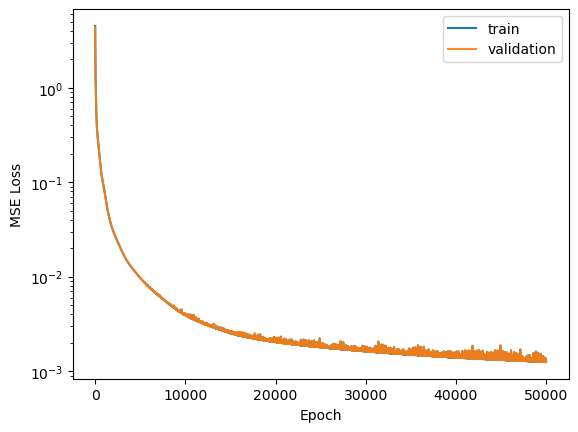

In [67]:
fig, ax = plt.subplots()
ax.plot(train_loss, label='train')
ax.plot(val_loss, label='validation', alpha=0.9)
ax.set_yscale('log')
ax.legend()
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')

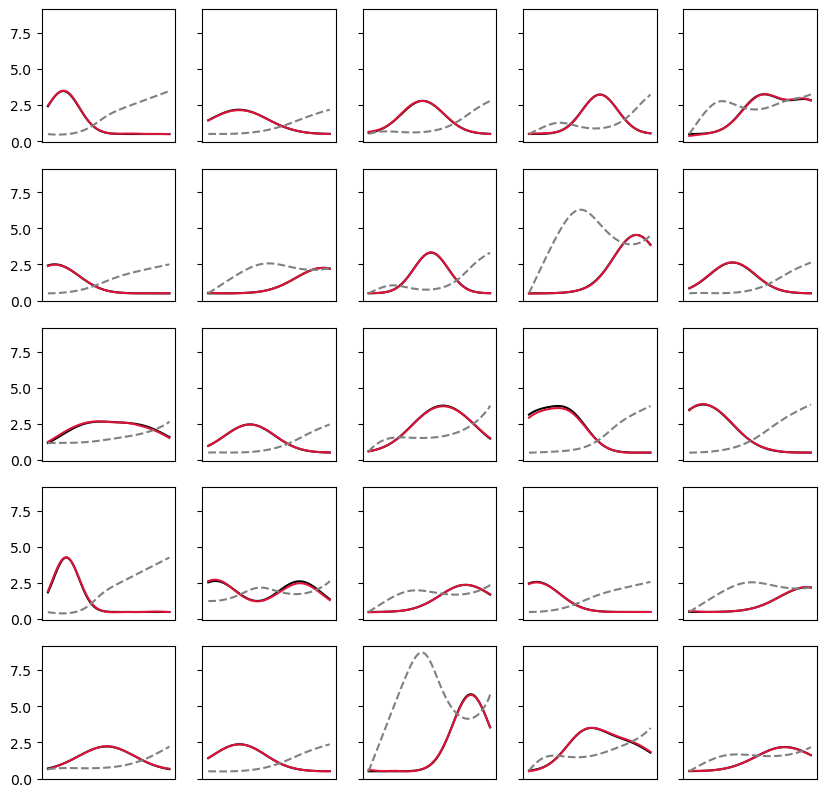

In [65]:
tds = train_ds
test_tensor = torch.tensor(tds['u'].values, dtype=model.dtype).to('cuda')
y_test = model(test_tensor).cpu().detach().numpy()
pred_da = xr.DataArray(y_test, dims=('sample', 'x'))
tds['d_pred'] = pred_da
err_da = (tds['d'] - tds['d_pred'])

fig, axes = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

samples = np.linspace(0, 999, len(axes)).astype(int)

for i, ax in zip(samples, axes):
    tds['d'].isel(sample=i).plot(ax=ax, color='black')
    tds['d_pred'].isel(sample=i).plot(ax=ax, color='crimson')
    tds['u'].isel(sample=i).plot(ax=ax, color='grey', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])

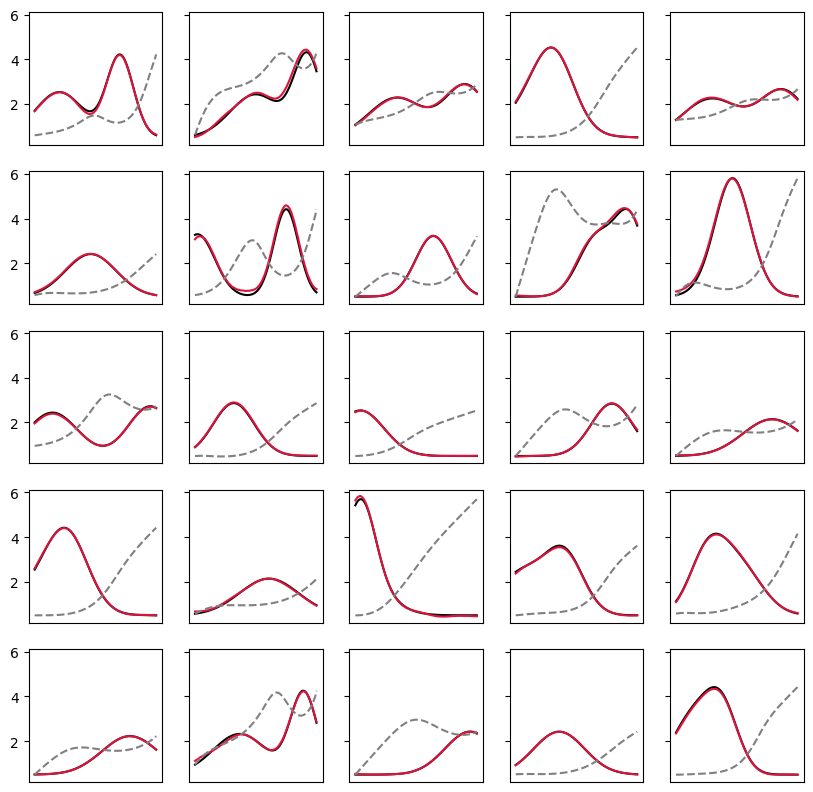

In [66]:
tds = test_ds
test_tensor = torch.tensor(tds['u'].values, dtype=model.dtype).to('cuda')
y_test = model(test_tensor).cpu().detach().numpy()
pred_da = xr.DataArray(y_test, dims=('sample', 'x'))
tds['d_pred'] = pred_da
err_da = (tds['d'] - tds['d_pred'])

fig, axes = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

samples = np.linspace(0, 999, len(axes)).astype(int)

for i, ax in zip(samples, axes):
    tds['d'].isel(sample=i).plot(ax=ax, color='black')
    tds['d_pred'].isel(sample=i).plot(ax=ax, color='crimson')
    tds['u'].isel(sample=i).plot(ax=ax, color='grey', linestyle='--')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])